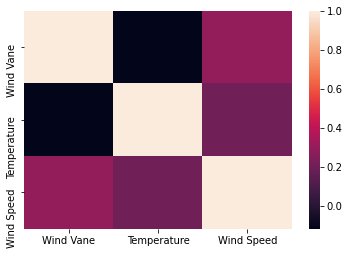

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Preprocessing data
df = pd.read_csv('Wind Dataset KU.csv')

df.dropna(inplace=True)

import seaborn as sn
sn.heatmap(df.corr())

training_set = df.iloc[:60180, 1:4].values
test_set = df.iloc[60180:, 1:4].values

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0,1))

training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.fit_transform(test_set)

test_set_scaled = test_set_scaled[:, 0:2]

X_train = []
y_train = []
WS = 144

for i in range(WS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i, 0:3])
    y_train.append(training_set_scaled[i,2])
    
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 3))

In [2]:
# Developing LSTM Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout


Model = Sequential()

Model.add(LSTM(units = 70, return_sequences = True, input_shape = (X_train.shape[1], 3)))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 70, return_sequences = True))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 70, return_sequences = True))
Model.add(Dropout(0.2))

Model.add(LSTM(units = 70))
Model.add(Dropout(0.2))

Model.add(Dense(units = 1))

Model.compile(optimizer = 'adam', loss = 'mean_squared_error')

Model.fit(X_train,y_train, epochs = 80, batch_size = 32)


Epoch 1/80
1877/1877 [==============================] - 573s 296ms/step - loss: 0.0021
Epoch 2/80
1877/1877 [==============================] - 533s 284ms/step - loss: 0.0011
Epoch 3/80
1877/1877 [==============================] - 531s 283ms/step - loss: 0.0010
Epoch 4/80
1877/1877 [==============================] - 528s 281ms/step - loss: 0.0010
Epoch 5/80
1877/1877 [==============================] - 527s 281ms/step - loss: 9.8629e-04
Epoch 6/80
1877/1877 [==============================] - 522s 278ms/step - loss: 9.8605e-04
Epoch 7/80
1877/1877 [==============================] - 518s 276ms/step - loss: 9.7013e-04
Epoch 8/80
1877/1877 [==============================] - 519s 276ms/step - loss: 9.7257e-04
Epoch 9/80
1877/1877 [==============================] - 518s 276ms/step - loss: 9.5965e-04
Epoch 10/80
1877/1877 [==============================] - 504s 268ms/step - loss: 9.5702e-04
Epoch 11/80
1877/1877 [==============================] - 503s 268ms/step - loss: 9.5548e-04
Epoch 12/80
1

In [3]:
#saving LSTM Model
Model.save('LSTM - Multivariatews')


INFO:tensorflow:Assets written to: LSTM - Multivariatews\assets


INFO:tensorflow:Assets written to: LSTM - Multivariatews\assets


In [4]:
#Prediction using LSTM
from keras.models import load_model
Model = load_model('LSTM - Multivariatews')

prediction_test = []

Batch_one = training_set_scaled[-144:]
Batch_New = Batch_one.reshape((1,144,3))

for i in range(288):
    
    First_pred = Model.predict(Batch_New)[0]
    
    prediction_test.append(First_pred)
    
    New_var = test_set_scaled[i,:]
    
    New_var = New_var.reshape(1,2)
    
    New_test = np.insert(New_var, 2, [First_pred], axis =1)
    
    New_test = New_test.reshape(1,1,3)
    
    Batch_New = np.append(Batch_New[:,1:,:], New_test, axis=1)
    
prediction_test = np.array(prediction_test)

SI = MinMaxScaler(feature_range = (0,1))
y_Scale = training_set[:,2:3]
SI.fit_transform(y_Scale)

predictions = SI.inverse_transform(prediction_test)

real_values = test_set[:, 2]

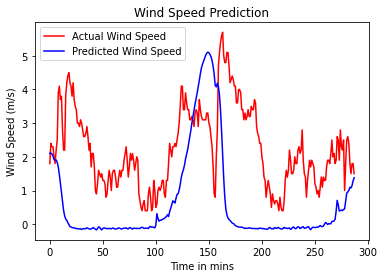

In [5]:
#Plotting the result
plt.plot(real_values, color = 'red', label = 'Actual Wind Speed')
plt.plot(predictions, color = 'blue', label = 'Predicted Wind Speed')
plt.title('Wind Speed Prediction')
plt.xlabel('Time in mins')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.show()

In [8]:
#Performance Measurement of Model
import math
from sklearn.metrics import mean_squared_error
RMSE = math.sqrt(mean_squared_error(real_values,predictions))


def mean_absolute_percentage_error (y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

MAPE = mean_absolute_percentage_error(real_values,predictions)

tm = real_values.mean()

pm = predictions.mean()

tstd = real_values.std()

pmstd = predictions.std()

print(MAPE)

103.42873948891982


In [9]:
print(tm)
print(pm)

2.240277777777778
0.6168217


In [10]:
print(tstd)
print(pmstd)

1.1760526871018604
1.3713158
